# Tutorial: Build Trusted ML models with Certifai on Azure Notebooks

This tutorial picks up after part one of the Azure regression tutorial. In part one you prepared the NYC taxi data for regression modeling. The referenced parts 1 & 2 can be found under My projects on the [Azure Notebooks Portal](https://notebooks.azure.com/)

In this tutorial, you learn:

> * How to set up a Certifai scan from scratch
> * How to run Explainability, Fairness and Robustness scans
> * Explore their results
> * Log Certifai results to the Azure portal

If you don't have an Azure subscription, create a [free account](https://aka.ms/AMLfree) before you begin. 

If you don't have the Certifai Toolkit, get it now from our [Certifai page](https://www.cognitivescale.com/download-certifai/)

## Usage/Preparation Steps
There are two ways to enjoy this tutorial
1. Running on Azure Notebooks: By logging to the [Azure Notebooks Portal](https://notebooks.azure.com/)
2. Running locally


### 1. Running on Azure Notebook portal
1. In the [Azure Notebooks Portal](https://notebooks.azure.com/) go to My Projects. Use the "Clone Repo" button on the top right. Clone this project's [repo](https://github.com/mdungarov-cs/cortex_certifai_azure_notebooks_ny_taxi.git)
2. Download the toolkit from [Certifai page](https://www.cognitivescale.com/download-certifai/) and unzip
3. Upload the cat_encoder.py from certifai_toolkit/examples/notebooks
4. Upload the scanner, engine and from certifai_toolkit/packages folder
5. Upload the requirements.txt file from the certifai_toolkit folder
6. Use terminal or your notebook to `pip install` the files from steps 3&4 (remember to `pip install -r` the requirements file)  
NB: if using hosted terminal to install dependencies: ensure it is in the right environment and running the right python version).  
NB: If using the notebook to install dependencies, you might need to restart the notebook after installations

You are all set!

### 2. Running locally

1. Ensure you have a Python 3.x notebook server with the following installed:
2. Install Azure SDK dependencies `pip install --upgrade azureml-sdk[notebooks,automl,widgets]`
3. Follow the instructions to install the Certifai toolkit and dependencies from the [documentation page](https://cognitivescale.github.io/cortex-certifai/docs/toolkit/setup/install-certifai-cli-lib)

You are all set!

# Tutorial Contents

1. Data prep
2. Training an AutoML model
3. Model Selection for Certifai scan
4. Certifai Scan Setup
5. Review of Results and Evaluation

# Data prep

This part follows closely part 2 of the tutorial mentioned before, with minor differences to data prep needed for Certifai to run properly.

We start by loading data from part 1, and selecting relevant columns, storing results as csv - Certifai will directly consume the data as a csv file. For some of the runs we can also do with a smaller dataset, hence we also prepare a `_sample` dataset with only 500 rows to shorten the time needed to run

In [4]:
import os
import azureml.dataprep as dprep

file_path = os.path.join(os.getcwd(), "dflows.dprep")
dflow_prepared = dprep.Dataflow.open(file_path)

dflow_reduced = dflow_prepared.keep_columns(['pickup_weekday','pickup_hour', 'distance',
                                             'passengers', 'vendor', 'cost'])

df=dflow_reduced.to_pandas_dataframe()

# NOTE: DATASET CANNOT HAVE AN INDEX COLUMN FOR CERTIFAI
df.to_csv('all_data_NY_Taxi.csv',index=False)
df.sample(500,random_state=0).to_csv('all_data_NY_Taxi_sample.csv',index=False)

Here, we split the data into test and train but also prepare the CatEncoder by specifying the correct columns as categoricals. This enables multi-processing in the context of a notebook

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import random
from cat_encoder import CatEncoder

In [9]:

base_path = '.'
all_data_file = f"{base_path}/all_data_NY_taxi.csv"
sample_data_file = f"{base_path}/all_data_NY_taxi_sample.csv"
df = pd.read_csv(all_data_file)

label_column = 'cost'

# Separate outcome
y = df[label_column]
X = df.drop(label_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

cat_columns = [
    'vendor',
    'pickup_weekday',
    'passengers'
    ]
# Note - to support python multi-processing in the context of a notebook the encoder MUST
# be in a separate file, which is why `CatEncoder` is defined outside of this notebook
encoder = CatEncoder(cat_columns, X)


# Training AutoML

The below simply runs Azure AutoML in the same fashion as in the Azure regression Tutorial after the minor modifications to the data and model encoder we had to do.

We will:
- log in to our Azure Workspace
- Set up and run AutoML
- Review results and select models for further review using Certifai

### Azure Workspace Login

- Type in your workspace credentials
- use those to creste a config file
- build workspace from config file

Please note that you need to populate the appropriate credentials

In [ ]:
subscription_id = os.getenv("SUBSCRIPTION_ID", default="<USER-SUBSCRIPTION-ID>")
resource_group = os.getenv("RESOURCE_GROUP", default="<USER-RESOURCE-GROUP>")
workspace_name = os.getenv("WORKSPACE_NAME", default="<USER-WORKSPACE-NAME>")
workspace_region = os.getenv("WORKSPACE_REGION", default="<USER-WORKSPACE-REGION>")

In [11]:
from azureml.core import Workspace

ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
# write the details of the workspace to a configuration file to the notebook library
ws.write_config()

In [12]:
from azureml.core.workspace import Workspace
ws = Workspace.from_config()

In [13]:
from azureml.core.experiment import Experiment
experiment = Experiment(ws, "taxi-experiment")

### Auto ML

Setup and run of Auto ML

In [14]:
import  logging

automl_settings = {
    "iteration_timeout_minutes": 2,
    "iterations": 20,
    "primary_metric": 'spearman_correlation',
    "featurization": 'auto',
    "verbosity": logging.INFO,
    "n_cross_validations": 5
}

In [15]:
from azureml.train.automl import AutoMLConfig

automl_config = AutoMLConfig(task='regression',
                             debug_log='automated_ml_errors.log',
                             X=encoder(np.array(X_train)),
                             y=y_train.values.flatten(),
                             **automl_settings)

/Users/mdungarov/opt/anaconda3/envs/taxi/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
WARNING - The AutoMLConfig inputs you have specified will soon be deprecated. Please use the AutoMLConfig shown in our documentation: https://aka.ms/AutoMLConfig


In [16]:

from azureml.core.experiment import Experiment
experiment = Experiment(ws, "taxi-experiment")
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_e6a7a6bc-1cb0-43a7-b746-35a6955afe92

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing values imputation
STATUS:       PASSED
DESCRIPTION:  There were no missing values found in the training data.

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.

****************************************************************************

In [17]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()


_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

# Model Selection for Certifai Scan

After training a range of models and can now select a pair of the best performing ones to evaluate with Certifai. Note that you can select any number of models to evaluate, however, we only pick two here for illustration.

From the above we see that the best performing model is the Voting Ensemble. Followed closely by a Stack Ensemble model. We will consider the Voting Ensemble to be our "Champion" model

For our challenger, we will use a the best performing Random Tree Classifier (Model 12, Extreme Random Trees). This is simply to demonstrate that in a Certifai context, model type does not make a difference and allows us to compare any selection of models

In [22]:
champ_run, champion_model = local_run.get_output()

challenger_run, challenger_model = local_run.get_output(12)


2020-03-30 13:21:32,684 root   INFO     All the dependencies and the corresponding versions in the environment are:
2020-03-30 13:21:32,685 root   INFO     azureml-automl-core==1.2.0;azureml-automl-runtime==1.2.0;azureml-contrib-notebook==1.2.0;azureml-core==1.2.0.post1;azureml-dataprep==1.3.5;azureml-dataprep-native==14.1.0;azureml-defaults==1.2.0;azureml-explain-model==1.2.0;azureml-interpret==1.2.0;azureml-model-management-sdk==1.0.1b6.post1;azureml-pipeline==1.2.0;azureml-pipeline-core==1.2.0;azureml-pipeline-steps==1.2.0;azureml-sdk==1.2.0;azureml-telemetry==1.2.0;azureml-train==1.2.0;azureml-train-automl==1.2.0;azureml-train-automl-client==1.2.0;azureml-train-automl-runtime==1.2.0;azureml-train-core==1.2.0;azureml-train-restclients-hyperdrive==1.2.0;azureml-widgets==1.2.0
2020-03-30 13:21:32,687 root   INFO     No issues found in the SDK package versions.
2020-03-30 13:21:34,607 root   INFO     All the dependencies and the corresponding versions in the environment are:
2020-03-30

# Certifai Scan Setup

The below sections take us through the scan setup. We start with library imports

In [19]:
from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)

Attempting to read logging config from: /Users/mdungarov/.certifai/log_config.ini


### Task definition

This is the core of what we will evaluate. Specifically, we will be running:

- Regression type task, as opposed to classification. The task is defined as `CertifaiTaskOutcomes.regression`
- The favorable outcome is a reduction of the outcome variable, ie we consider favorable for the Taxi Ride to cost less rather than more `increased_favorable=False`
- significant change is about 50% of the empirical standard deviation. `change_std_deviation=0.5`. In this case, the empirical standard deviation is about $9.6, hence we consider significant change to be about $5. 


We start defining a scan by assigning it this prediction task. In the remaining steps we will add additional characteristics of the scan

In [25]:

task = CertifaiPredictionTask(CertifaiTaskOutcomes.regression(
        increased_favorable=False,
        change_std_deviation=0.5),
    prediction_description='Predict taxi fare based on features of the trip')

scan = CertifaiScanBuilder.create('test_user_case',
                                  prediction_task=task)

### Adding Models & Data to the Scan

We add the selected models to the scan. Here, we use a PredictorWrapper

We also add the dataset by specifying its location. Here this is done via the `all_data_file` value we set earlier when preparing the data for training. Notice that this is simply a pointer to the location of the dataset 

In [26]:
# Wrap the model up for use by Certifai as a local model
champion_model_proxy = CertifaiPredictorWrapper(champion_model, encoder=encoder)
challenger_model_proxy = CertifaiPredictorWrapper(challenger_model, encoder=encoder)

# Add our local models
first_model = CertifaiModel('champion',
                            local_predictor=champion_model_proxy)
scan.add_model(first_model)

second_model = CertifaiModel('challenger',
                            local_predictor=challenger_model_proxy)
scan.add_model(second_model)

# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv(all_data_file))
scan.add_dataset(eval_dataset)
eval_dataset = CertifaiDataset('explanation',
                               CertifaiDatasetSource.csv(sample_data_file))
scan.add_dataset(eval_dataset)

scan.evaluation_dataset_id = 'evaluation'
# For this analysis we'll generate explanations for the entire dataset so we have a good number
# on which to base statistical measures
scan.explanation_dataset_id = 'explanation'

### Adding Evaluations

Adding evaluations is now very simple, one can just list the ones needed and those will be run by the scan and included in the result object.

Notice that for 'explanation' and 'robustness', simply adding evaluation is sufficient to have the report run. For fairness, we also need to specify the actual sensitive feature we want to assess 'fairness' for. In this case: `passengers` feature

In [27]:
# Setup an evaluation for explanation on the above dataset using the model
scan.add_evaluation_type('explanation')
scan.add_evaluation_type('robustness')
scan.add_evaluation_type('fairness')

scan.add_fairness_grouping_feature(CertifaiGroupingFeature('passengers'))


# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = scan.run(write_reports=False)

2020-03-30 13:22:13,852 root   INFO     Validating license...
2020-03-30 13:22:13,854 root   INFO     License is valid - expires: n/a
2020-03-30 13:22:13,869 root   INFO     Generated unique scan id: f39b33968c8f
2020-03-30 13:22:13,870 root   INFO     Validating input data...
2020-03-30 13:22:13,871 root   INFO     Creating dataset with id: evaluation
2020-03-30 13:22:13,891 root   INFO     Inferring dataset features and applying user overrides
2020-03-30 13:22:13,899 root   WARNING  Using fallback implementation of: median_absolute_deviation
2020-03-30 13:22:13,902 root   WARNING  Using fallback implementation of: median_absolute_deviation
2020-03-30 13:22:13,906 root   WARNING  Using fallback implementation of: median_absolute_deviation
2020-03-30 13:22:13,909 root   WARNING  Using fallback implementation of: median_absolute_deviation
2020-03-30 13:22:13,912 root   INFO     Inferring dataset features and applying user overrides
2020-03-30 13:22:13,919 root   WARNING  Using fallback 

2020-03-30 13:34:08,724 root   INFO     Batch run time per generation for instances 352 to 383: 0.07202
2020-03-30 13:34:31,451 root   INFO     Batch run time per generation for instances 384 to 415: 0.06729
2020-03-30 13:34:55,390 root   INFO     Batch run time per generation for instances 416 to 447: 0.06422
2020-03-30 13:35:18,673 root   INFO     Batch run time per generation for instances 448 to 479: 0.06236
2020-03-30 13:35:33,720 root   INFO     Batch run time per generation for instances 480 to 499: 0.06580
2020-03-30 13:35:33,742 root   INFO     Model used: champion
2020-03-30 13:35:33,743 root   INFO     CERScore is 0.9319266988482893
2020-03-30 13:35:33,744 root   INFO     NCERScore is 0.10298485940842812
2020-03-30 13:35:33,745 root   INFO     Normalization constant is 9.049162218616592
2020-03-30 13:35:33,746 root   INFO     Total run time in seconds: 799.6648092269897
2020-03-30 13:35:33,747 root   INFO     Total Samples: 13041
2020-03-30 13:35:33,748 root   INFO     Avera

2020-03-30 13:39:11,775 root   INFO     Current max sampling error 0.02973491636438385 (max for early stop 0.005102040816326531)
2020-03-30 13:39:11,775 root   INFO     Current min non-exhausted protected class samples 26 (min for early stop 100)
2020-03-30 13:39:31,986 root   INFO     Batch run time per generation for instances 160 to 191: 0.07607
2020-03-30 13:39:31,987 root   INFO     Current max sampling error 0.029076858406593905 (max for early stop 0.005102040816326531)
2020-03-30 13:39:31,987 root   INFO     Current min non-exhausted protected class samples 32 (min for early stop 100)
2020-03-30 13:39:55,964 root   INFO     Batch run time per generation for instances 192 to 223: 0.07814
2020-03-30 13:39:55,965 root   INFO     Current max sampling error 0.029091729400194746 (max for early stop 0.005102040816326531)
2020-03-30 13:39:55,966 root   INFO     Current min non-exhausted protected class samples 37 (min for early stop 100)
2020-03-30 13:40:19,964 root   INFO     Batch run

2020-03-30 13:48:10,583 root   INFO     Current max sampling error 0.013522418701256233 (max for early stop 0.005102040816326531)
2020-03-30 13:48:10,584 root   INFO     Current min non-exhausted protected class samples 171 (min for early stop 100)
2020-03-30 13:48:32,617 root   INFO     Batch run time per generation for instances 896 to 927: 0.06446
2020-03-30 13:48:32,618 root   WARNING  Examples of protected class (3, 3) exhausted before convergence after 174 samples
2020-03-30 13:48:32,619 root   INFO     Current max sampling error 0.01312982783464548 (max for early stop 0.005102040816326531)
2020-03-30 13:48:32,620 root   INFO     Current min non-exhausted protected class samples 178 (min for early stop 100)
2020-03-30 13:48:54,546 root   INFO     Batch run time per generation for instances 928 to 959: 0.06793
2020-03-30 13:48:54,547 root   INFO     Current max sampling error 0.012838429602260285 (max for early stop 0.005102040816326531)
2020-03-30 13:48:54,548 root   INFO     Cur

2020-03-30 13:56:51,691 root   INFO     Batch run time per generation for instances 1600 to 1631: 0.06407
2020-03-30 13:56:51,692 root   INFO     Current max sampling error 0.008739914261532731 (max for early stop 0.005102040816326531)
2020-03-30 13:56:51,693 root   INFO     Current min non-exhausted protected class samples 405 (min for early stop 100)
2020-03-30 13:57:13,240 root   INFO     Batch run time per generation for instances 1632 to 1663: 0.07002
2020-03-30 13:57:13,241 root   INFO     Current max sampling error 0.008600481975418291 (max for early stop 0.005102040816326531)
2020-03-30 13:57:13,242 root   INFO     Current min non-exhausted protected class samples 415 (min for early stop 100)
2020-03-30 13:57:35,603 root   INFO     Batch run time per generation for instances 1664 to 1695: 0.06504
2020-03-30 13:57:35,605 root   INFO     Current max sampling error 0.008485337623635932 (max for early stop 0.005102040816326531)
2020-03-30 13:57:35,605 root   INFO     Current min no

2020-03-30 14:04:51,173 root   INFO     Gini coefficient is [{'feature': 'passengers', 'value': 84.580852865026, 'value_confidence_95_lower': 77.48733069882375, 'value_confidence_95_upper': 91.56188129686853}]
2020-03-30 14:04:51,174 root   INFO     Model used: champion
2020-03-30 14:04:51,174 root   INFO     CERScore is 1.1196996074098389
2020-03-30 14:04:51,175 root   INFO     NCERScore is 0.14174686790110314
2020-03-30 14:04:51,176 root   INFO     Normalization constant is 7.899289938392529
2020-03-30 14:04:51,177 root   INFO     Total run time in seconds: 1628.9049241542816
2020-03-30 14:04:51,178 root   INFO     Total Samples: 25804
2020-03-30 14:04:51,178 root   INFO     Average feature reduction applied to counterfactuals: 0.0
2020-03-30 14:04:51,274 root   INFO     Completed fairness report for model champion
2020-03-30 14:04:51,277 root   INFO     Creating ATX report for model: champion
2020-03-30 14:04:51,280 root   INFO     performing evaluation: explanation, for model: chal

2020-03-30 14:12:50,468 root   INFO     Running analysis variant 'prediction changed'
2020-03-30 14:12:50,539 root   WARNING  Using fallback implementation of: median_absolute_deviation
2020-03-30 14:12:50,540 root   WARNING  Using fallback implementation of: median_absolute_deviation
2020-03-30 14:12:50,542 root   WARNING  Using fallback implementation of: median_absolute_deviation
2020-03-30 14:12:50,544 root   WARNING  Using fallback implementation of: median_absolute_deviation
2020-03-30 14:12:51,331 root   INFO     Running with explanation reduction ON
2020-03-30 14:12:51,333 root   INFO     Total dataset size is 6246
2020-03-30 14:13:10,100 root   INFO     Batch run time per generation for instances 0 to 31: 0.04865
2020-03-30 14:13:10,101 root   INFO     Current max sampling error 0.008206751882880366 (max for early stop 0.005102040816326531)
2020-03-30 14:13:10,101 root   INFO     Current min non-exhausted protected class samples 32 (min for early stop 100)
2020-03-30 14:13:25,

2020-03-30 14:16:33,378 root   INFO     Current max sampling error 0.025607240656347573 (max for early stop 0.005102040816326531)
2020-03-30 14:16:33,379 root   INFO     Current min non-exhausted protected class samples 62 (min for early stop 100)
2020-03-30 14:16:48,502 root   INFO     Batch run time per generation for instances 352 to 383: 0.04077
2020-03-30 14:16:48,503 root   INFO     Current max sampling error 0.024501119308771337 (max for early stop 0.005102040816326531)
2020-03-30 14:16:48,505 root   INFO     Current min non-exhausted protected class samples 68 (min for early stop 100)
2020-03-30 14:17:02,762 root   INFO     Batch run time per generation for instances 384 to 415: 0.04209
2020-03-30 14:17:02,765 root   INFO     Current max sampling error 0.023481146384377028 (max for early stop 0.005102040816326531)
2020-03-30 14:17:02,765 root   INFO     Current min non-exhausted protected class samples 75 (min for early stop 100)
2020-03-30 14:17:18,200 root   INFO     Batch ru

2020-03-30 14:22:02,431 root   INFO     Batch run time per generation for instances 1056 to 1087: 0.04542
2020-03-30 14:22:02,432 root   INFO     Current max sampling error 0.010747211862993471 (max for early stop 0.005102040816326531)
2020-03-30 14:22:02,433 root   INFO     Current min non-exhausted protected class samples 223 (min for early stop 100)
2020-03-30 14:22:16,557 root   INFO     Batch run time per generation for instances 1088 to 1119: 0.04060
2020-03-30 14:22:16,557 root   INFO     Current max sampling error 0.010305120619693589 (max for early stop 0.005102040816326531)
2020-03-30 14:22:16,558 root   INFO     Current min non-exhausted protected class samples 234 (min for early stop 100)
2020-03-30 14:22:31,351 root   INFO     Batch run time per generation for instances 1120 to 1151: 0.04485
2020-03-30 14:22:31,352 root   INFO     Current max sampling error 0.009921039984694801 (max for early stop 0.005102040816326531)
2020-03-30 14:22:31,352 root   INFO     Current min no

2020-03-30 14:28:01,171 root   INFO     Current max sampling error 0.007758578852332954 (max for early stop 0.005102040816326531)
2020-03-30 14:28:01,171 root   INFO     Current min non-exhausted protected class samples 469 (min for early stop 100)
2020-03-30 14:28:15,788 root   INFO     Batch run time per generation for instances 1824 to 1855: 0.04658
2020-03-30 14:28:15,789 root   INFO     Current max sampling error 0.00784402504171699 (max for early stop 0.005102040816326531)
2020-03-30 14:28:15,790 root   INFO     Current min non-exhausted protected class samples 479 (min for early stop 100)
2020-03-30 14:28:30,082 root   INFO     Batch run time per generation for instances 1856 to 1887: 0.04511
2020-03-30 14:28:30,083 root   INFO     Current max sampling error 0.007726510572737477 (max for early stop 0.005102040816326531)
2020-03-30 14:28:30,084 root   INFO     Current min non-exhausted protected class samples 490 (min for early stop 100)
2020-03-30 14:28:45,039 root   INFO     Ba

2020-03-30 14:33:14,227 root   INFO     Batch run time per generation for instances 2559 to 2622: 0.04897
2020-03-30 14:33:14,228 root   INFO     Current max sampling error 0.005846613508534033 (max for early stop 0.005102040816326531)
2020-03-30 14:33:14,229 root   INFO     Current min non-exhausted protected class samples 777 (min for early stop 100)
2020-03-30 14:33:28,652 root   INFO     Batch run time per generation for instances 2623 to 2686: 0.04194
2020-03-30 14:33:28,653 root   INFO     Current max sampling error 0.005715533264257674 (max for early stop 0.005102040816326531)
2020-03-30 14:33:28,653 root   INFO     Current min non-exhausted protected class samples 809 (min for early stop 100)
2020-03-30 14:33:42,100 root   INFO     Batch run time per generation for instances 2687 to 2750: 0.04313
2020-03-30 14:33:42,100 root   INFO     Current max sampling error 0.0055505144847107545 (max for early stop 0.005102040816326531)
2020-03-30 14:33:42,101 root   INFO     Current min n

# Review of Certifai Scan Results

The results of the scan are stored in an extensive result variable. Here we would like to just preview the high-level outcomes.

## Explanations
We start with model level explanations to gauge what are the main drivers of taxi fares.

What we will do here is essentially aggregate the number of times a certain variable has been used for generating a counterfactual, thus assessing its overall importance to the model

The outcome is not surprising - by far the most important variable is distance traveled. Second in only a third of the first is pickup hour, which also makes sense as in some cases late evening and early morning hours are charged differently. Number of passengers  as well as the actual vendor used seem to play the least role in determining the fare. All of this is good as it validates our expectations on how taxi fares work and the sensibility of the models we have in place.

Notice, that crucially, this level of detail is rarely available from simply training a model in itself or interpretability might be lost due to latent and/or dummy features generated along the way of making the model work. This analysis, however, is crucial for our understanding, confidence and ultimately trust in the behavior of the model

In [31]:
%load_ext autoreload

In [40]:
%autoreload 2
from tutorial_utils import get_feature_frequency, plot_histogram,plot_fairness_burden

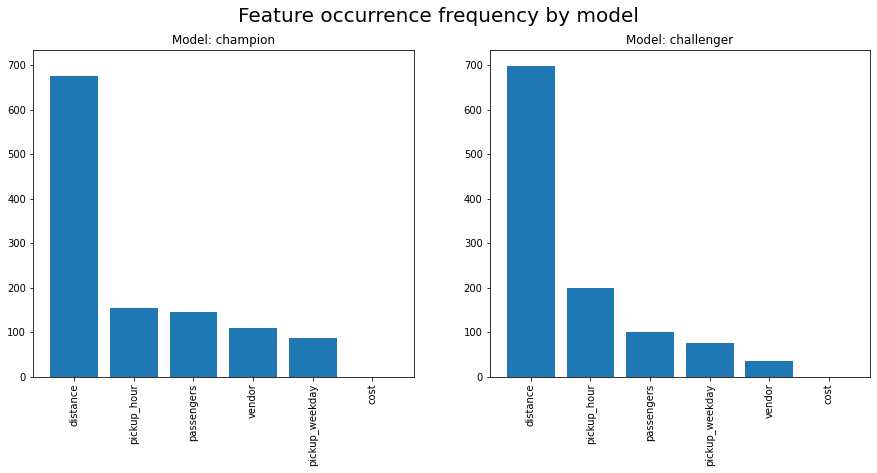

In [37]:
# Plot a histogram of frequency of occurrence of changes to each feature in counterfactuals
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,6])
fig.suptitle('Feature occurrence frequency by model', fontsize=20)

plot_histogram(ax1, 'champion', result)
plot_histogram(ax2, 'challenger', result)

# Put them both on the same scale
ylim = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(top=ylim)
ax2.set_ylim(top=ylim)

plt.show()

## Fairness to different sized groups

Finally, we set out here to determine the fairness of Taxi fares between differently sized groups of riders

Looking at the results it seems that the burden on all groups is largely the same with groups of 4 passengers seemingly receiving a slightly higher burden than others. However, those also come with a much wider confidence range which, when taken into account, makes them not significantly different from other groups. Additionally, looking at group counts, groups of 4 are also far less present in the sample - only 41 examples out of ca 6250.


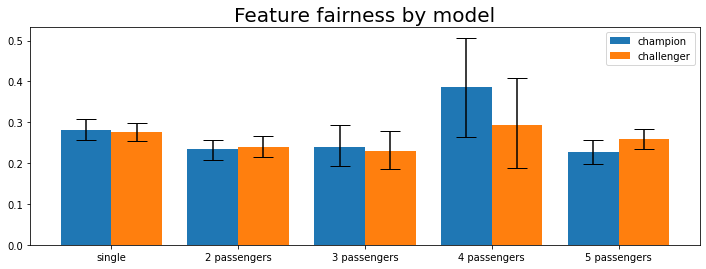

In [42]:
%matplotlib inline

from certifai.scanner.report_utils import scores, construct_scores_dataframe


df_rslt=construct_scores_dataframe(scores('fairness', result, max_depth=1))

group_categories=[f"({i}.0)" for i in range(1,6)]
group_xlabels=['single']+[f'{i} passengers' for i in range(2,6)]

plot_fairness_burden(df_rslt,group_categories,group_xlabels)

# Logging Results

Finally, using the workspace we already set up and assign a dedicated experiment for these runs. Here, we can log some key metrics for future reference

In [21]:

experiment = Experiment(ws, "certifai-rslt")

run = experiment.start_logging()
run.log('Fairness-Champion',value=result['fairness']['champion']['fairness']['score'])
run.log('Fairness-Challenger',value=result['fairness']['challenger']['fairness']['score'])
run.complete()